# Preprocessing pipeline
Credits: https://miykael.github.io/nipype_tutorial/

At the moment, this notebook has been coded to be tested on a single subject.
Other subjects can be easily added to the "subject_list". Some small changes have to be done to the names of the images called in the notebook in order to generalize the script to all subjects.

Before the preprocessing, the data format was modified using the bash function dcm2nii.

In [1]:
%matplotlib inline
from os.path import join as opj
import os
import json
from nipype.interfaces.fsl import (BET, ExtractROI, FAST, FLIRT, ImageMaths,
                                   MCFLIRT, SliceTimer, Threshold)
from nipype.interfaces.spm import Smooth
from nipype.interfaces.utility import IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.algorithms.rapidart import ArtifactDetect
from nipype.pipeline.engine import Workflow, Node, MapNode
from nipype.interfaces.ants import ApplyTransforms
from nipype.interfaces.fsl import Info

from nilearn import image, plotting
import numpy as np
import pylab as plt
import numpy as np
from IPython.display import SVG

In [2]:
# DEBUG MODE:
#preproc.config['execution'] = {'stop_on_first_rerun': 'True',
#                                   'hash_method': 'timestamp'}
#from nipype import config, logging
#config.enable_debug_mode()
#logging.update_logging(config)

We first define all the directories and variables that we are going to use among the notebook. The TR is the repetition time, that is the interval of time between two acquisitions.

In [3]:
experiment_dir = '/Users/elisabettamessina/PycharmProjects/ADAproject'
output_dir = 'output_folder'
working_dir = 'workingdir'

# list of subject identifiers
subject_list = ['sub-3310']

# list of session identifiers
task_list = ['rs']

# Smoothing widths to apply
fwhm = [4, 8]

# TR of functional images
TR = 2.4 

# Isometric resample of functional images to voxel size (in mm)
iso_size = 4

# Template to normalize to
template = experiment_dir + '/workingdir/PPMI/derivatives/fmriprep/template/T1_standard.nii'

### Defining nodes
In the following cell we are going to define all the nodes of the preprocessing workflow, that are the separate steps that have to be performed. 
The main transformations are going to be motion correction (realignment), smoothing and co-registration, while the other nodes are functional to the main ones. In the future, the normalization node will be added to this workflow.

In [4]:
# ExtractROI - skip dummy scans
extract = Node(ExtractROI(t_min=4, t_size=-1),
               output_type='NIFTI',
               name="extract")

# MCFLIRT - motion correction
mcflirt = Node(MCFLIRT(mean_vol=True,
                       save_plots=True,
                       output_type='NIFTI'),
               name="mcflirt")

# SliceTimer - correct for slice wise acquisition
slicetimer = Node(SliceTimer(index_dir=False,
                             interleaved=True,
                             output_type='NIFTI',
                             time_repetition=TR),
                  name="slicetimer")

# Smooth - image smoothing
smooth = Node(Smooth(), name="smooth")
smooth.iterables = ("fwhm", fwhm)

# Normalization

# Artifact Detection - determines outliers in functional images
art = Node(ArtifactDetect(norm_threshold=2,
                          zintensity_threshold=3,
                          mask_type='spm_global',
                          parameter_source='FSL',
                          use_differences=[True, False],
                          plot_type='svg'),
           name="art")

# BET - Skullstrip anatomical Image
bet_anat = Node(BET(frac=0.5,
                    robust=True,
                    output_type='NIFTI_GZ'),
                name="bet_anat")

# FAST - Image Segmentation
segmentation = Node(FAST(output_type='NIFTI_GZ'),
                name="segmentation")

# Select WM segmentation file from segmentation output
def get_wm(files):
    return files[-1]

# Threshold - Threshold WM probability image
threshold = Node(Threshold(thresh=0.5,
                           args='-bin',
                           output_type='NIFTI_GZ'),
                name="threshold")

# FLIRT - pre-alignment of functional images to anatomical images
coreg_pre = Node(FLIRT(dof=6, output_type='NIFTI_GZ'),
                 name="coreg_pre")

# FLIRT - coregistration of functional images to anatomical images with BBR
coreg_bbr = Node(FLIRT(dof=6,
                       cost='bbr',
                       schedule=opj(os.getenv('FSLDIR'),
                                    'etc/flirtsch/bbr.sch'),
                       output_type='NIFTI_GZ'),
                 name="coreg_bbr")

# Apply coregistration warp to functional images
applywarp = Node(FLIRT(interp='spline',
                       apply_isoxfm=iso_size,
                       output_type='NIFTI'),
                 name="applywarp")

# Apply coregistration warp to mean file
applywarp_mean = Node(FLIRT(interp='spline',
                            apply_isoxfm=iso_size,
                            output_type='NIFTI_GZ'),
                 name="applywarp_mean")

### Coregistration workflow
The nypipe library provides us a smart and easy way to connect different nodes into a sequential workflow. We can first connect the nodes for the coregistration workflow, which will be then added to the main pre-processing workflow.

In [5]:
# Create a coregistration workflow
coregwf = Workflow(name='coregwf')
coregwf.base_dir = opj(experiment_dir, working_dir)

# Connect all components of the coregistration workflow
coregwf.connect([(bet_anat, segmentation, [('out_file', 'in_files')]),
                 (segmentation, threshold, [(('partial_volume_files', get_wm),
                                             'in_file')]),
                 (bet_anat, coreg_pre, [('out_file', 'reference')]),
                 (threshold, coreg_bbr, [('out_file', 'wm_seg')]),
                 (coreg_pre, coreg_bbr, [('out_matrix_file', 'in_matrix_file')]),
                 (coreg_bbr, applywarp, [('out_matrix_file', 'in_matrix_file')]),
                 (bet_anat, applywarp, [('out_file', 'reference')]),
                 (coreg_bbr, applywarp_mean, [('out_matrix_file', 'in_matrix_file')]),
                 (bet_anat, applywarp_mean, [('out_file', 'reference')]),
                 ])

Now we need to specify where the input data can be found and where and how to save the output data.

In [6]:
# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['subject_id', 'task_name']),
                  name="infosource")
infosource.iterables = [('subject_id', subject_list),
                        ('task_name', task_list)]

# SelectFiles - to grab the data (alternativ to DataGrabber)
anat_file = opj('derivatives', 'fmriprep', '{subject_id}', 'anat', '{subject_id}_t1w.nii')
func_file = opj('{subject_id}', 'ses-test', 'func',
                '{subject_id}_ses-test_task-{task_name}_bold.nii.gz')

templates = {'anat': anat_file,
             'func': func_file}
selectfiles = Node(SelectFiles(templates,
                               base_directory= experiment_dir + '/workingdir/PPMI/'),
                   name="selectfiles")

# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="datasink")

## Use the following DataSink output substitutions
substitutions = [('_subject_id_', ''),
                 ('_task_name_', '/task-'),
                 ('_fwhm_', 'fwhm-'),
                 ('_roi', ''),
                 ('_mcf', ''),
                 ('_st', ''),
                 ('_flirt', ''),
                 ('.nii_mean_reg', '_mean'),
                 ('.nii.par', '.par'),
                 ]
subjFolders = [('fwhm-%s/' % f, 'fwhm-%s_' % f) for f in fwhm]
substitutions.extend(subjFolders)
datasink.inputs.substitutions = substitutions

### Main preprocessing workflow

In [7]:
# Create a preprocessing workflow
preproc = Workflow(name='preproc')
preproc.base_dir = opj(experiment_dir, working_dir)

# Connect all components of the preprocessing workflow
preproc.connect([(infosource, selectfiles, [('subject_id', 'subject_id'),
                                            ('task_name', 'task_name')]),
                 (selectfiles, extract, [('func', 'in_file')]),
                 (extract, mcflirt, [('roi_file', 'in_file')]),
                 (mcflirt, slicetimer, [('out_file', 'in_file')]),

                 (selectfiles, coregwf, [('anat', 'bet_anat.in_file'),
                                         ('anat', 'coreg_bbr.reference')]),
                 (mcflirt, coregwf, [('mean_img', 'coreg_pre.in_file'),
                                     ('mean_img', 'coreg_bbr.in_file'),
                                     ('mean_img', 'applywarp_mean.in_file')]),
                 (slicetimer, coregwf, [('slice_time_corrected_file', 'applywarp.in_file')]),
                 
                 (coregwf, smooth, [('applywarp.out_file', 'in_files')]),

                 (mcflirt, datasink, [('par_file', 'preproc.@par')]),
                 (smooth, datasink, [('smoothed_files', 'preproc.@smooth')]),
                 (coregwf, datasink, [('applywarp_mean.out_file', 'preproc.@mean')]),

                 (coregwf, art, [('applywarp.out_file', 'realigned_files')]),
                 (mcflirt, art, [('par_file', 'realignment_parameters')]),

                 (coregwf, datasink, [('coreg_bbr.out_matrix_file', 'preproc.@mat_file'),
                                      ('bet_anat.out_file', 'preproc.@brain')]),
                 (art, datasink, [('outlier_files', 'preproc.@outlier_files'),
                                  ('plot_files', 'preproc.@plot_files')]),
                 ])

### Let's run it!

In [8]:
preproc.run('MultiProc', plugin_args={'n_procs': 4})

171128-23:46:51,645 workflow INFO:
	 Workflow preproc settings: ['check', 'execution', 'logging']
171128-23:46:51,673 workflow INFO:
	 Running in parallel.
171128-23:46:51,677 workflow INFO:
	 Executing: selectfiles.b0 ID: 0
171128-23:46:51,683 workflow INFO:
	 Executing node selectfiles.b0 in dir: /Users/elisabettamessina/PycharmProjects/ADAproject/workingdir/preproc/_subject_id_sub-3310_task_name_rs/selectfiles
171128-23:46:51,705 workflow INFO:
	 [Job finished] jobname: selectfiles.b0 jobid: 0
171128-23:46:51,709 workflow INFO:
	 Executing: extract.b0 ID: 1
171128-23:46:51,712 workflow INFO:
	 [Job finished] jobname: extract.b0 jobid: 1
171128-23:46:51,714 workflow INFO:
	 Executing: bet_anat.b0 ID: 4
171128-23:46:51,716 workflow INFO:
	 [Job finished] jobname: bet_anat.b0 jobid: 4
171128-23:46:51,719 workflow INFO:
	 Executing: mcflirt.b0 ID: 2
171128-23:46:51,721 workflow INFO:
	 [Job finished] jobname: mcflirt.b0 jobid: 2
171128-23:46:51,723 workflow INFO:
	 Executing: segmentati

### Checking results
At this point we can show how the obtained images look like.

/Users/elisabettamessina/.local/lib/python3.6/site-packages/nilearn/image/resampling.py:481: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


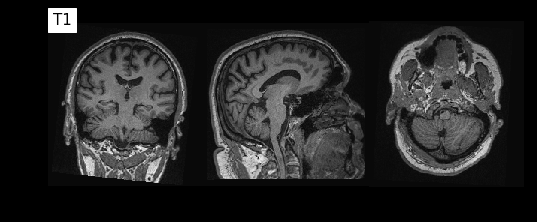

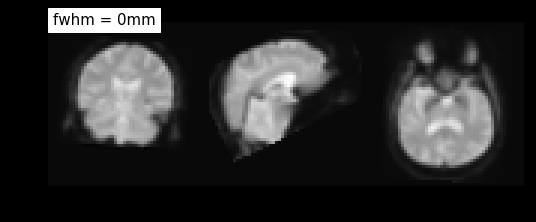

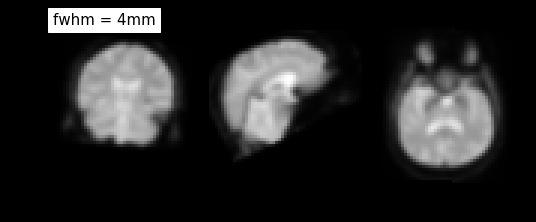

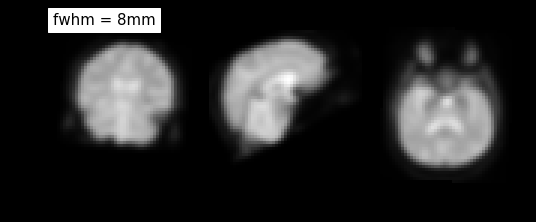

In [9]:
plotting.plot_epi(
    experiment_dir + '/workingdir/PPMI/derivatives/fmriprep/sub-3310/anat/sub-3310_t1w.nii',
    title="T1", display_mode='ortho', annotate=False, draw_cross=False, cmap='gray')

out_path = experiment_dir + '/output_folder/preproc/sub-3310/task-rs'
plotting.plot_epi(opj(out_path, 'sub-3310_ses-test_task-rs_bold_mean.nii.gz'),
                  title="fwhm = 0mm", display_mode='ortho', annotate=False, draw_cross=False, cmap='gray')
                                                 

plotting.plot_epi(image.mean_img(opj(out_path, 'fwhm-4_ssub-3310_ses-test_task-rs_bold.nii')),
                  title="fwhm = 4mm", display_mode='ortho', annotate=False, draw_cross=False, cmap='gray')

plotting.plot_epi(image.mean_img(opj(out_path, 'fwhm-8_ssub-3310_ses-test_task-rs_bold.nii')),
                  title="fwhm = 8mm", display_mode='ortho', annotate=False, draw_cross=False, cmap='gray')

In the following, we look at the motion parameters and check wheter the artifact detection algorithm was able to exclude the outliers.

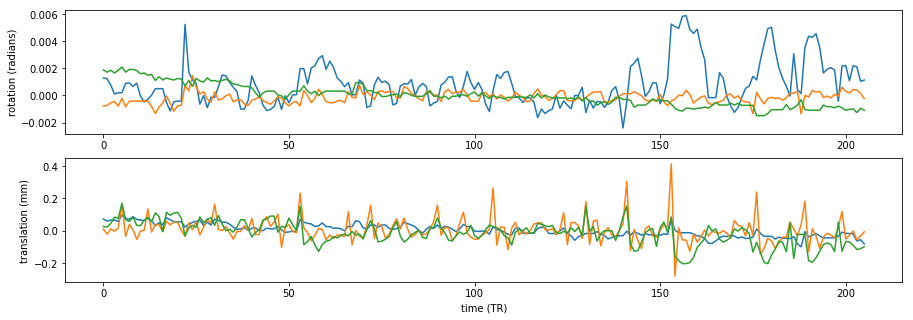

In [10]:
par = np.loadtxt(experiment_dir + '/output_folder/preproc/sub-3310/task-rs/sub-3310_ses-test_task-rs_bold.par')
fig, axes = plt.subplots(2, 1, figsize=(15, 5))
axes[0].set_ylabel('rotation (radians)')
axes[0].plot(par[0:, :3])
axes[1].plot(par[0:, 3:])
axes[1].set_xlabel('time (TR)')
axes[1].set_ylabel('translation (mm)')

Outliers were detected at volumes: [ 1.  2.  3.]


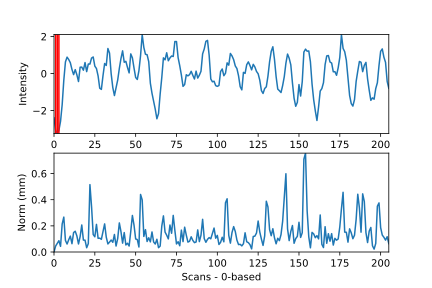

In [11]:
outlier_ids = np.loadtxt(experiment_dir + '/output_folder/preproc/sub-3310/task-rs/art.sub-3310_ses-test_task-rs_bold_outliers.txt')
print('Outliers were detected at volumes: %s' % outlier_ids)

SVG(filename=experiment_dir + '/output_folder/preproc/sub-3310/task-rs/plot.sub-3310_ses-test_task-rs_bold.svg')

## Next steps:
* Time courses extraction
* Preprocess all subjects 
* Machine learning

Have a look to the README for more details!